In [1]:
#default_exp evaluation

In [2]:
#export

import os
import pickle
import attr
from typing import List

import pandas as pd
import scipy
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

from game_recommender import steam_data, content_based, user_based, hybrid
from mlutil.evolutionary_algorithms import multiobjective

np.random.seed(0)

Using TensorFlow backend.


In [3]:
%cd ..

/home/kuba/Projects/game_recommender


In [4]:
game_dataset = steam_data.get_steam_ratings_dataset()

In [5]:
user_based_recommender = user_based.UserBasedRecommender.make_from_steam_data('log_hours')
content_based_recommender = content_based.ContentBasedRecommender.make_from_steam_metadata()

# Recommendation evaluation metrics

We will use two ranking metrics to evaluate the recommender.


## recall@k
It is  essentially false negative rate for top $k$ items. For a sequence $I$ of ratings and $\hat{I}$ of predicted items 

$recall@k(I, \hat{I}) = \frac{1}{min(k, |I|)}|I \cap \hat{I}| $

## Kendall's $\tau$
The second metric is used to measure how similar are orderings of $I$ and $\hat{I}$.

For a pair of zipped of items from $I, I'$

$((i_k, i'_k)$ $(i_j, i'_j))$ is said to be *concordant* if their signs are not zero and coincide: $sign(i_k -  i_j) = sign(i'_k - i'_j)$. It is said to be *disconcordant* if the signs are not equal.

Kendall rank correlation coefficient for two rankings with $n_c$ concordant pairs and $n_d$ disconcordant pairs is defined as

$\tau = \frac{n_c - n_d}{n \choose k}$


## Tradeoffs

Since recall measures false negative rate, increasing number of recommended items will never decrease it. On the other hand adding recommendations changes ranking, so by adding noisy entries it might decrease $\tau$



In [6]:
#export


class metrics:
        
    @staticmethod
    def get_correlation(user_ratings, recommendations, method=scipy.stats.kendalltau):
        user_ratings_with_zeros, recommendations_with_zeros, n_compared = metrics._make_data_for_correlation_comparison(user_ratings, recommendations) 
        return method(user_ratings_with_zeros[:n_compared], recommendations_with_zeros[:n_compared])[0]

    @staticmethod
    def get_recall_at(user_ratings, recommendations, k=10):
        user_games = user_ratings.sort_values(ascending=False)[:k]
        recommended_games = recommendations.sort_values(ascending=False)[:k]
        return recommended_games.index.isin(user_games.index).sum() / len(user_games)

    @staticmethod
    def _fill_nonexistent_with_zeros(source, target):
        not_in_source = target[~target.index.isin(source.index)].index
        zeroed_not_in_source = pd.Series(index=not_in_source, data=np.zeros_like(not_in_source))
        return pd.concat([source, zeroed_not_in_source])

    @staticmethod
    def _make_data_for_correlation_comparison(user_ratings, recommendations):
        user_ratings_with_zeros = metrics._fill_nonexistent_with_zeros(recommendations, user_ratings)
        recommendations_with_zeros = metrics._fill_nonexistent_with_zeros(user_ratings, recommendations)[user_ratings_with_zeros.index]
        n_compared = min([len(user_ratings), len(recommendations)])
        return user_ratings_with_zeros, recommendations_with_zeros, n_compared


In [7]:
user_item_df = game_dataset.get_user_item_df()

# Evaluating recommendations for an example user

In [8]:
i = 10
user_id = user_based_recommender.user_similarity_searcher.df.iloc[i,0]
user_ratings_raw = user_item_df.iloc[i]
user_ratings = user_ratings_raw[~user_ratings_raw.isna()]

In [9]:
user_ratings

name
counter strike                     3.135494
counter strike global offensive    6.194405
counter strike nexon zombies       0.693147
counter strike source              0.693147
day of defeat                      0.693147
deathmatch classic                 0.693147
eldevin                            0.693147
half life                          0.693147
half life blue shift               0.693147
half life opposing force           0.693147
planetside 2                       0.693147
raceroom racing experience         0.336472
realm of the mad god               0.693147
ricochet                           0.693147
team fortress classic              0.693147
unturned                           0.693147
warface                            0.693147
Name: 547685, dtype: float64

### Example recommendations

In [10]:
recommender = hybrid.HybridRecommender(content_based_recommender, user_based_recommender)
recommendations = recommender.get_weighted_recommendations(user_ratings, 20, user_recommendation_weight=1, content_recommendation_weight=1, mean_content_recommendation_weight=1)
recommendations

counter strike global offensive    2.800790
call of duty 4 modern warfare      2.518721
world of tanks blitz mmo           1.916409
counter strike                     1.832181
tanki online                       1.738157
blockade classic                   1.729970
team fortress 2                    0.986183
warface                            0.967958
post scriptum                      0.961721
planetside 2                       0.957287
call of duty black ops 2           0.956847
argo                               0.954355
squad                              0.952416
counter strike source              0.913655
counter strike nexon zombies       0.883508
tera                               0.804729
arma 2 operation arrowhead         0.795574
supreme commander 2                0.760804
insurgency                         0.746282
rise of liberty                    0.713363
dtype: float64

Recall

In [11]:
metrics.get_recall_at(user_ratings, recommendations)

0.3

Kendall $\tau$

In [12]:
metrics.get_correlation(user_ratings, recommendations, method=scipy.stats.kendalltau)

0.12871918058696763

# Hybrid recommender

Hybrid recommender combines three recommendation methods:

1. user-based similarity

2. content-based similarity

3. mean content based similarity


Using recommendations from different sources gives is beneficial because different methods may suffer from different problems.


### 1. User-based similarity

This method for given ratings calculates users that have similar taste: it compares users using cosine similarity of their ratings.

User-based collaborative filtering is 

Drawbacks:

- cold start problem - we do not know what to recommend to users that have very few ratings.
- the method will have very different quality depending on number of rated items. In our dataset we have less than 20 ratings for most of users, but some of them rated more than 100 games.


### 2. Content-based similarity

Calculates similarity, but for items instead of users. Then returns games that were similar to rated games - their ratings are interpolated from rated games weighted by cosine similarity.

For content features [steam metadata](https://www.kaggle.com/trolukovich/steam-games-complete-dataset) was used: for each game columns with tags and descriptions were vectorized using TF-IDF.

By definition will recommend items similar to the ones that were rated. This may result in too conservative recommendations - there is no serendipity.

### 3. Mean content-based similarity

This method computes mean of item feature vectors and then 

In [13]:
@attr.s
class HybridRecommenderEvaluator:
    
    recommender: hybrid.HybridRecommender = attr.ib()
        
    def get_per_user_recommendation_groups(self, users_ratings, n_recommended=20, n_similar_users=10, n_similar_items=10):
        return [recommender.get_recommendation_groups(user_ratings, n_similar_users, n_similar_items) for user_ratings in users_ratings]
    
    def get_metric_values(
            self,
            users_ratings,
            user_recommendations_groups,
            n_recommended,
            metric,
            user_recommendation_weight=1,
            content_recommendation_weight=1,
            mean_content_recommendation_weight=1
            ):
        
        weights = [user_recommendation_weight, content_recommendation_weight, mean_content_recommendation_weight]
        metric_values = [
            metric(users_ratings, recommender.weigh_recommendations(user_recommendation_group, weights, n_recommended))
            for users_ratings, user_recommendation_group in zip(user_ratings, user_recommendations_groups)
        ]
        return pd.Series(metric_values)

In [14]:
class HybridRecommenderOptimizer:
    
    def __init__(
            self,
            evaluator: HybridRecommenderEvaluator,
            users_ratings: List[pd.Series],
            n_recommended=10,
            n_similar_users=5,
            n_similar_items=5,
            k_recall=10):
        self.evaluator = evaluator
        self.users_ratings = users_ratings
        self.n_recommended = n_recommended
        self.recommendation_groups = evaluator.get_per_user_recommendation_groups(user_ratings, n_recommended, n_similar_users, n_similar_items)
        self.k_recall = k_recall
    
    def problem_function(self, weights):
        if len(weights) == 2:
            [user_recommendation_weight, content_recommendation_weight] = weights
            mean_content_recommendation_weight = max(0, 1 - user_recommendation_weight - content_recommendation_weight)
        else:
            [user_recommendation_weight, content_recommendation_weight, mean_content_recommendation_weight] = weights / weights.sum() 
        recall = self.evaluator.get_metric_values(
            self.users_ratings,
            self.recommendation_groups,
            self.n_recommended,
            partial(metrics.get_recall_at, k=self.k_recall),
            user_recommendation_weight,
            content_recommendation_weight,
            mean_content_recommendation_weight
        )

        rank_correlation = self.evaluator.get_metric_values(
            self.users_ratings,
            self.recommendation_groups,
            self.n_recommended,
            metrics.get_correlation,
            user_recommendation_weight,
            content_recommendation_weight,
            mean_content_recommendation_weight
        )
        return np.array([recall.mean(), rank_correlation.mean()])
    
    def problem_function_vectorized(self, weights):
        recalls = []
        rank_correlations = []
        for i in range(len(weights)):
            recall, rank_correlation = self.problem_function(weights[i])
            recalls.append(recall.mean())
            rank_correlations.append(rank_correlation.mean())
        return np.column_stack([recalls, rank_correlations])


# Evaluating Hybrid Recommender

Since our recommenders use kNN models, it makes sense to evaluate recommendations for separate users separately: this is basically Leave One Out scheme for crossvalidation.

In [15]:
user_item_df_with_rankings = user_item_df[user_item_df.var(axis=1) > 1e-4]

In [16]:
n_test = 100 
users_ratings_raw = user_item_df_with_rankings.iloc[:n_test]
user_ratings = [ratings.dropna() for (__, ratings) in users_ratings_raw.iterrows()]
rating_counts = [len(ratings) for ratings in user_ratings]

In [17]:
evaluator = HybridRecommenderEvaluator(recommender)

In [18]:
%%time
optimizer = HybridRecommenderOptimizer(evaluator, user_ratings)

CPU times: user 18.9 s, sys: 859 ms, total: 19.8 s
Wall time: 19.8 s


In [19]:
rec_groups = optimizer.recommendation_groups

## Baseline results 

Baseline results are retrieved using equal weights for different recommendation methods.

## recall@10

0.635

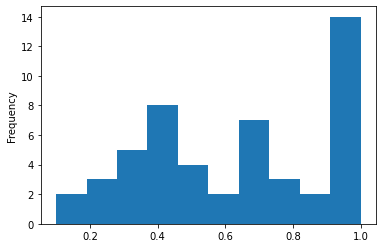

In [20]:
recall = evaluator.get_metric_values(rec_groups, rec_groups, 10, metrics.get_recall_at, 1, 1, 1)
recall.plot.hist()
round(recall.mean(), 3)

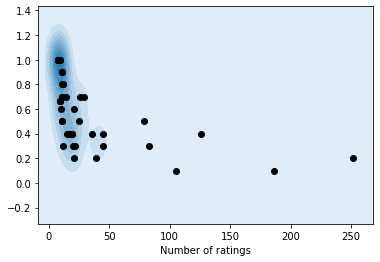

In [21]:
plt.xlabel('Number of ratings')
plt.ylabel('recall@10')
sns.kdeplot(rating_counts, recall, shade=True);
plt.scatter(rating_counts, recall, data=None, c='black');

## Kendall $\tau$

0.122

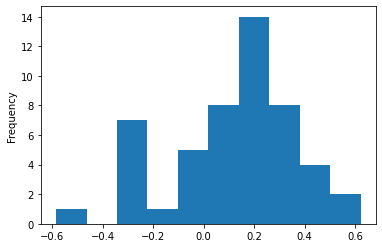

In [22]:
tau = evaluator.get_metric_values(rec_groups, rec_groups, 10, partial(metrics.get_correlation, method=scipy.stats.kendalltau), 1, 1, 1)
tau.plot.hist()
round(tau.mean(), 3)

In [23]:
import seaborn as sns

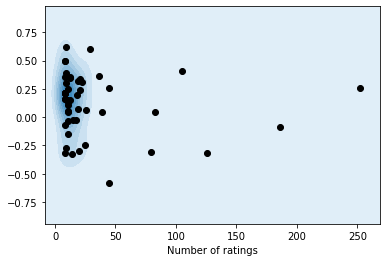

In [24]:
plt.xlabel('Number of ratings')
plt.ylabel('Kendall tau')
sns.kdeplot(rating_counts, tau, shade=True);
plt.scatter(rating_counts, tau, data=None, c='black');

## Multiobjective optimization

Since we're interested in optimizing with respect to two metrics, we need to use multiobjective optimization methods.

One evolutionary method that can be used with multiple criterions is [NSGA-II algorithm](https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf).

In the following we try to find Pareto frontier for jointly optimizing recall and Kendall $\tau$.

In [60]:
nsga_alg = multiobjective.NSGAII(
    optimizer.problem_function,
    chromosome_size=3,
    mutation_function=partial(multiobjective.bounded_gaussian_noise_mutation, sigma=0.05),
    objective_names=('recall@10', 'Kendall tau')
)

  0%|          | 0/10 [00:00<?, ?it/s]

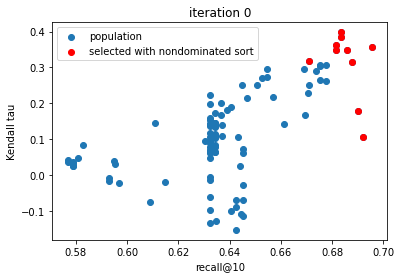

 10%|█         | 1/10 [00:30<04:33, 30.39s/it]

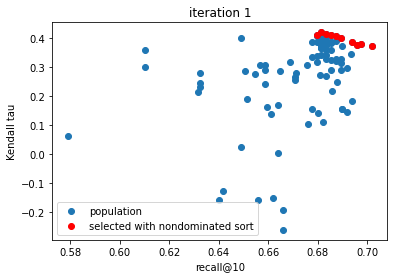

 20%|██        | 2/10 [01:01<04:04, 30.52s/it]

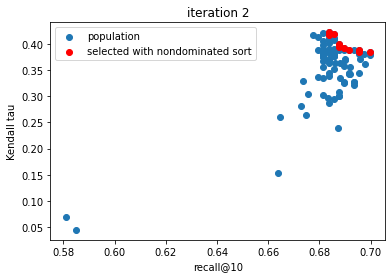

 30%|███       | 3/10 [01:32<03:34, 30.61s/it]

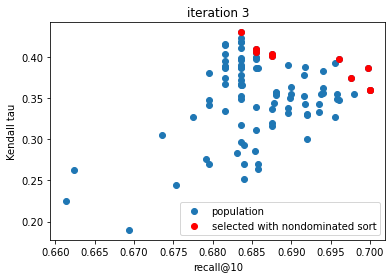

 40%|████      | 4/10 [02:03<03:04, 30.75s/it]

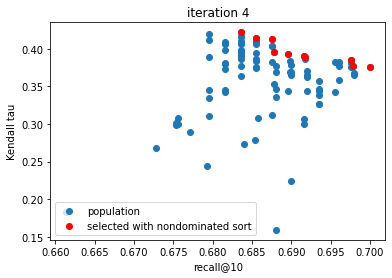

 50%|█████     | 5/10 [02:34<02:35, 31.05s/it]

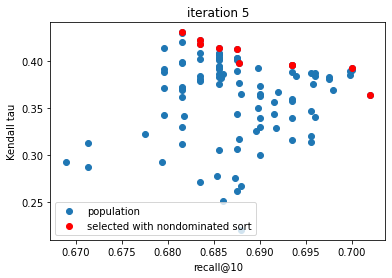

 60%|██████    | 6/10 [03:05<02:04, 31.01s/it]

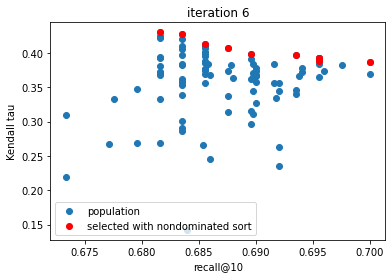

 70%|███████   | 7/10 [03:36<01:33, 31.01s/it]

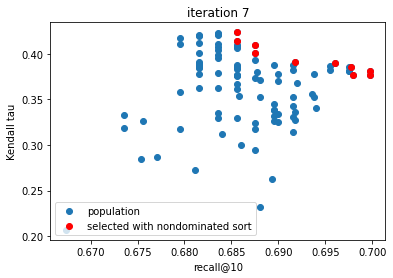

 80%|████████  | 8/10 [04:07<01:01, 30.97s/it]

In [ ]:
%%time
recommender_weights_simple = nsga_alg.optimize(population_size=100, n_selected=10, n_iterations=10, minimize=False, log_period=1)

  0%|          | 0/10 [00:00<?, ?it/s]

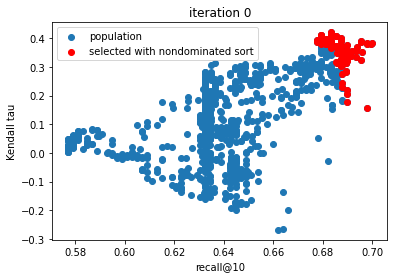

 10%|█         | 1/10 [05:06<46:02, 306.93s/it]

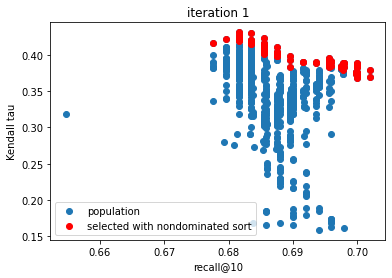

 20%|██        | 2/10 [10:10<40:47, 305.96s/it]

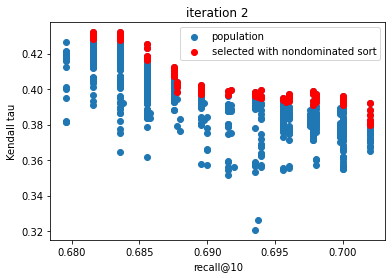

 30%|███       | 3/10 [15:30<36:10, 310.03s/it]

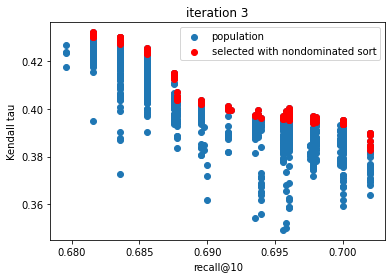

 40%|████      | 4/10 [20:42<31:03, 310.62s/it]

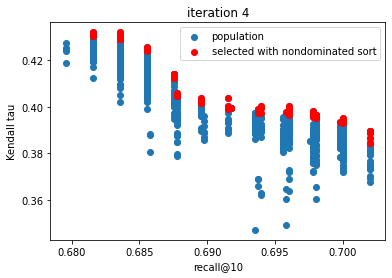

 50%|█████     | 5/10 [25:47<25:45, 309.02s/it]

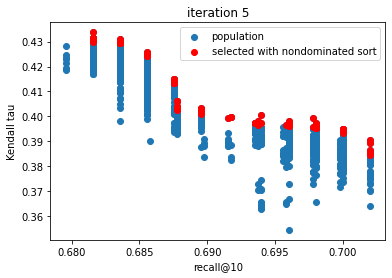

 60%|██████    | 6/10 [30:50<20:29, 307.27s/it]

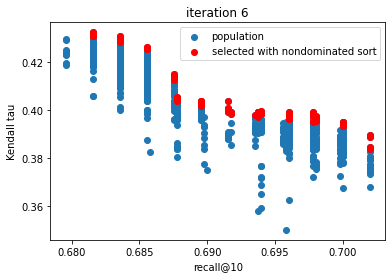

 70%|███████   | 7/10 [35:58<15:21, 307.30s/it]

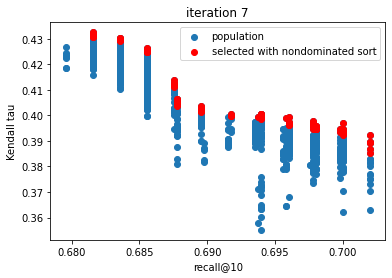

 80%|████████  | 8/10 [41:05<10:14, 307.39s/it]

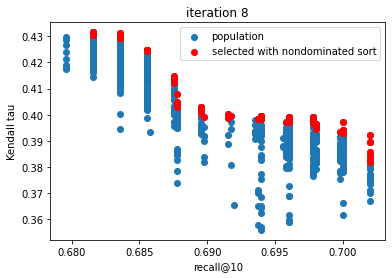

 90%|█████████ | 9/10 [46:14<05:07, 307.95s/it]

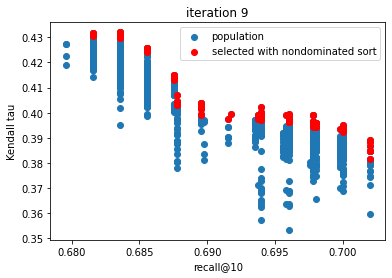

100%|██████████| 10/10 [51:23<00:00, 308.39s/it]

CPU times: user 51min 26s, sys: 1.44 s, total: 51min 27s
Wall time: 51min 23s


In [27]:
%%time
recommender_weights = nsga_alg.optimize(population_size=1000, n_selected=100, n_iterations=10, minimize=False, log_period=1)

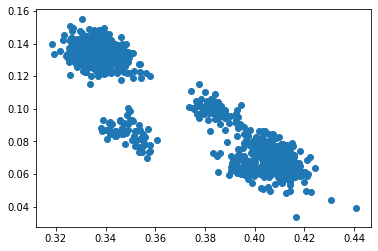

In [50]:
plt.scatter(norm_weights[:,0], norm_weights[:,1]);
sns.kdeplot(norm_weights[:,0], norm_weights[:,1], shade=True, sharex=True);

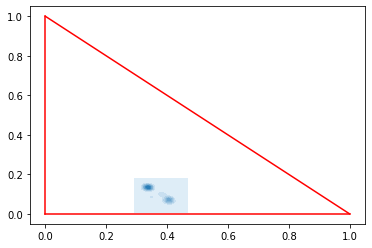

In [59]:
norm_weights = recommender_weights / recommender_weights.sum(axis=1)[:,np.newaxis]
plt.scatter(norm_weights[:,0], norm_weights[:,1]);

plt.plot([0, 1], [1, 0], c='red')
plt.plot([0, 0], [1, 0], c='red')
plt.plot([0, 1], [0, 0], c='red')